<a href="https://colab.research.google.com/github/cisimon7/Non-Contact-Measurement-of-Cable-Profile/blob/main/main/CV_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Non-Contact Measurement of Cable Profile
To measure sagging and other properties of the cable using images of the cable so as to improve Robot Positioning Accuracy

<b>Goal of this project</b>
<ol>
<li>Repeatability: Measurement of positioning while attaining a particular pose multiple times</li>
<li>Directional Accuracy: Accuracy in different positions of the end effector in it's workspace</li>
</ol>

##### <b><i>Linking notebooks</i></b>

In [68]:
from IPython.display import clear_output
!pip install kora -q
from kora import drive
drive.link_nbs()

# import Aruco_Helpers
from Simulation import Simulation
from IPython.display import clear_output 
from Catenary_Predictor import CatenaryPredictor

clear_output()

##### <b><i>Imports</i></b>

In [69]:
import os
import re
import sys
import cv2
import yaml
import torch
import numpy as np
from cv2 import aruco
from matplotlib import pyplot as plt

##### <b><i>Downloading Dataset</i></b>

In [70]:
!git clone https://github.com/RABKKK/CableDrivenRobotCableModel.git
clear_output()

##### <b><i>Utilities Functions</i></b>

In [71]:
 def read_and_resize_image(filename, grayscale = False, fx= 0.5, fy=0.5):
    if grayscale:
      img_result = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
    else:
      imgbgr = cv2.imread(filename, cv2.IMREAD_COLOR)
      img_result = cv2.cvtColor(imgbgr, cv2.COLOR_BGR2RGB)
    img_result = cv2.resize(img_result, None, fx=fx, fy=fy, interpolation = cv2.INTER_CUBIC)
    return img_result
  
def showInRow(list_of_images, titles = None, disable_ticks = False):
  plt.rcParams["figure.figsize"] = (16, 10) # (w, h)
  count = len(list_of_images)
  for idx in range(count):
    subplot = plt.subplot(1, count, idx+1)
    if titles is not None:
      subplot.set_title(titles[idx])
      
    img = list_of_images[idx]
    cmap = 'gray' if (len(img.shape) == 2 or img.shape[2] == 1) else None
    subplot.imshow(img, cmap=cmap)
    if disable_ticks:
      plt.xticks([]), plt.yticks([])
  plt.show()

def readYAMLFile(fileName):
  ret = {}
  skip_lines=1    # Skip the first line which says "%YAML:1.0". Or replace it with "%YAML 1.0"
  with open(fileName) as fin:
    for i in range(skip_lines):
        fin.readline()
    yamlFileOut = fin.read()
    myRe = re.compile(r":([^ ])")   # Add space after ":", if it doesn't exist. Python yaml requirement
    yamlFileOut = myRe.sub(r': \1', yamlFileOut)
    ret = yaml.load(yamlFileOut)
  return ret

In [72]:
def search_for_line(image):
    to_return = image.copy()
    to_return = cv2.cvtColor(to_return, cv2.COLOR_RGB2GRAY)
    to_return = cv2.GaussianBlur(to_return, (7, 7), 0)  # Remove inconsistencies

    # Find a line
    to_return = cv2.adaptiveThreshold(to_return, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 51, 12)

    # Remove some noise
    kernel_dilation = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    kernel_erosion = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))

    to_return = cv2.erode(to_return, kernel_erosion)
    to_return = cv2.dilate(to_return, kernel_dilation)

    return to_return

In [73]:
def Rx(q):
  return np.array([
      [1, 0,         0          ],
      [0, np.cos(q), -np.sin(q) ],
      [0, np.sin(q), np.cos(q)  ]
  ])

def Ry(q):
  return np.array([
      [np.cos(q),  0, np.sin(q) ],
      [0,          1, 0         ],
      [-np.sin(q), 0, np.cos(q) ]
  ])

def Rz(q):
  return np.array([
      [np.cos(q), -np.sin(q), 0 ],
      [np.sin(q), np.cos(q),  0 ],
      [0,         0,          1 ]
  ])

def rot_mat(euler_angles):
  qx, qy, qz = euler_angles
  return Rx(qx) @ Ry(qy) @ Rz(qz)

##### <b><i>Testing on a single Frame</i></b>

In [74]:
# Get Video
video_example1 = "/content/CableDrivenRobotCableModel/baumer_video0048.avi"
video_example2 = "/content/CableDrivenRobotCableModel/baumer_video0043.avi"

# Open video with cv2
cap = cv2.VideoCapture(video_example2)
ret, frame = cap.read()           
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

In [75]:
# Function to filter detected fiduciary markers in the image
def is_not_ok(image):
  # Take the image
  # unwrap it if possible to be a square
  # binarize it
  # Checks

  image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  dst = cv2.cornerHarris(image,2,3,0.04)

  if (len(dst)>10  and len(image[image<20])>50) : return False 

  return True

In [76]:
cameraParams = cv2.FileStorage("/content/baumer12mm1mf.yml", cv2.FILE_STORAGE_READ)
cameraMatrix = cameraParams.getNode("camera_matrix").mat()
distCoef = cameraParams.getNode("distortion_coefficients").mat()

Pose estimation using AruCo markers

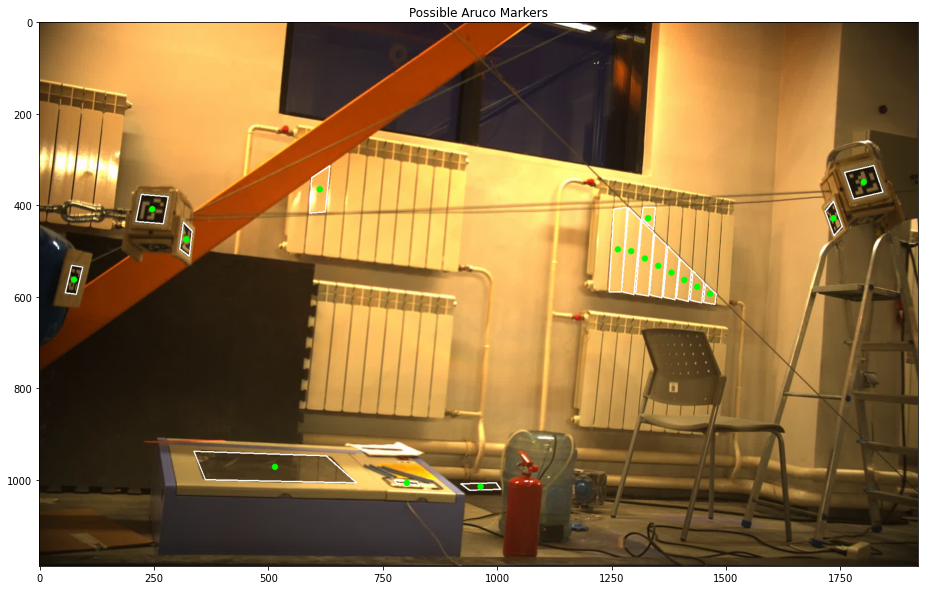

In [77]:
frame_copy = frame.copy()

aruco_dict = cv2.aruco.Dictionary_get(cv2.aruco.DICT_APRILTAG_36h11)
aruco_params = cv2.aruco.DetectorParameters_create()
(corners, ids, rejected) = cv2.aruco.detectMarkers(frame_copy, aruco_dict, parameters=aruco_params)

for i,markerCorner in enumerate(rejected):

  corners = markerCorner.reshape((4, 2))
  (topLeft, topRight, bottomRight, bottomLeft) = corners.astype(int)

  topRight = (topRight[0], topRight[1])
  bottomRight = (bottomRight[0], bottomRight[1])
  bottomLeft = (bottomLeft[0], bottomLeft[1])
  topLeft = (topLeft[0], topLeft[1])

  x1 = min(topLeft[0], bottomLeft[0])
  x2 = max(topRight[0], bottomRight[0])
  y1 = max(topRight[1], topRight[1])
  y2 = min(bottomRight[1], bottomLeft[1])

  x1, x2 = np.sort([x1,x2])
  y1, y2 = np.sort([y1,y2])

  # draw the bounding box of the ArUCo detection
  cv2.line(frame_copy, topLeft, topRight, (255, 255, 255), 2)
  cv2.line(frame_copy, topRight, bottomRight, (255, 255, 255), 2)
  cv2.line(frame_copy, bottomRight, bottomLeft, (255, 255, 255), 2)
  cv2.line(frame_copy, bottomLeft, topLeft, (255, 255, 255), 2)

  cx = int((topLeft[0] + bottomRight[0]) / 2.0)
  cy = int((topLeft[1] + bottomRight[1]) / 2.0)
  cv2.circle(frame_copy, (cx, cy), 7, (0, 255, 0), -1)
  # centers.append([cx, cy])

showInRow([frame_copy], ["Possible Aruco Markers"])

Detetction of AruCo markers applying filtering and Corresponding Axis Drawn

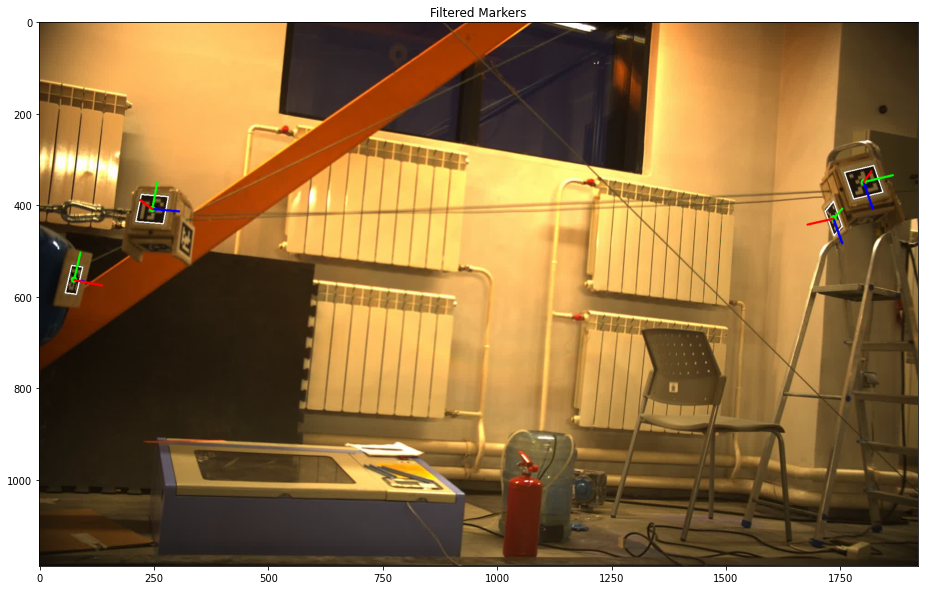

In [78]:
frame_copy = frame.copy()
idx     = []  # Corners rejected idexes
centers = []  # Centre of accepted markers

arucoDict = cv2.aruco.Dictionary_get(cv2.aruco.DICT_6X6_250)
arucoParams = cv2.aruco.DetectorParameters_create()
(corners, ids, rejected) = cv2.aruco.detectMarkers(frame_copy, aruco_dict, 
                                                   parameters=aruco_params,
                                                   cameraMatrix=cameraMatrix,
                                                   distCoeff=distCoef)

for i,markerCorner in enumerate(rejected):

  corners = markerCorner.reshape((4, 2))
  (topLeft, topRight, bottomRight, bottomLeft) = corners.astype(int)

  topRight = (topRight[0], topRight[1])
  bottomRight = (bottomRight[0], bottomRight[1])
  bottomLeft = (bottomLeft[0], bottomLeft[1])
  topLeft = (topLeft[0], topLeft[1])

  x1 = min(topLeft[0], bottomLeft[0])
  x2 = max(topRight[0], bottomRight[0])
  y1 = max(topRight[1], topRight[1])
  y2 = min(bottomRight[1], bottomLeft[1])

  x1, x2 = np.sort([x1,x2])
  y1, y2 = np.sort([y1,y2])

  if is_not_ok(frame[y1:y2, x1:x2, : ]): 
    continue
  idx.append(i)

  # draw the bounding box of the ArUCo detection
  cv2.line(frame_copy, topLeft, topRight, (255, 255, 255), 2)
  cv2.line(frame_copy, topRight, bottomRight, (255, 255, 255), 2)
  cv2.line(frame_copy, bottomRight, bottomLeft, (255, 255, 255), 2)
  cv2.line(frame_copy, bottomLeft, topLeft, (255, 255, 255), 2)

  cx = int((topLeft[0] + bottomRight[0]) / 2.0)
  cy = int((topLeft[1] + bottomRight[1]) / 2.0)
  cv2.circle(frame_copy, (cx, cy), 7, (0, 255, 0), -1)
  centers.append([cx, cy])

rvec, tvec, ids = aruco.estimatePoseSingleMarkers(np.array(rejected).astype(np.float64), 0.05, cameraMatrix, distCoef)
for i in range(len(tvec)):
  if (i in idx): 
    aruco.drawAxis(frame_copy, cameraMatrix, distCoef, rvec[i], tvec[i], 0.05)

showInRow([frame_copy], ["Filtered Markers"])

Selection of Cable in the image

In [79]:
block1_yml = readYAMLFile("/content/block1.yml")
block2_yml = readYAMLFile("/content/block2.yml")

In [80]:
def corners_by_id(id, marker_yml):
  """given marker id and a list of markers, function returns the corners of a marker"""
  markers = marker_yml["aruco_bc_markers"]
  return list(filter(lambda mark: (mark["id"] == id), markers))[0]["corners"]

In [81]:
low_box  = np.genfromtxt('AxisCentreBlock1.csv', delimiter=' ', dtype=float)
high_box = np.genfromtxt('AxisCentreBlock2.csv', delimiter=' ', dtype=float)

In [82]:
# From C++ code
TB = np.array([
      [-0.094228685,   0.99537355, 0.018768981,  -1.6779985],
      [   0.9809584,  0.096046865, -0.16880554, -0.71926367],
      [  -0.1698273, 0.0025052801, -0.98547065,   4.0799942],
      [           0,            0,           0,           1]
])

In [ ]:
low_box[0]

array([-0.06199857,  0.96776639,  0.24409915])

In [92]:
low_box[2]

array([  1.95927584,  -2.42608795, -59.06527351])

In [131]:
block_rvec = low_box[0]
block_tvec = low_box[2]/1000

block_rvec_img = np.array([block_rvec]) # TB[:-1,:] @ np.append(block_rvec, 1) 
block_tvec_img = TB[:-1,:] @ np.append(block_tvec, 1) # @ cameraMatrix 

block_rvec_img = block_rvec_img.ravel()
block_tvec_img = block_tvec_img.ravel()

# block_rvec_img = block_rvec_img/block_rvec_img[-1]
block_tvec_img = block_tvec_img/block_tvec_img[-1]

[block_rvec_img, block_tvec_img]

[array([-0.05231079,  0.99771685, -0.04271613]),
 array([-0.40641916, -0.17100718,  1.        ])]

In [ ]:
# [-0.08694475,  0.1766027 ,  1.        ]

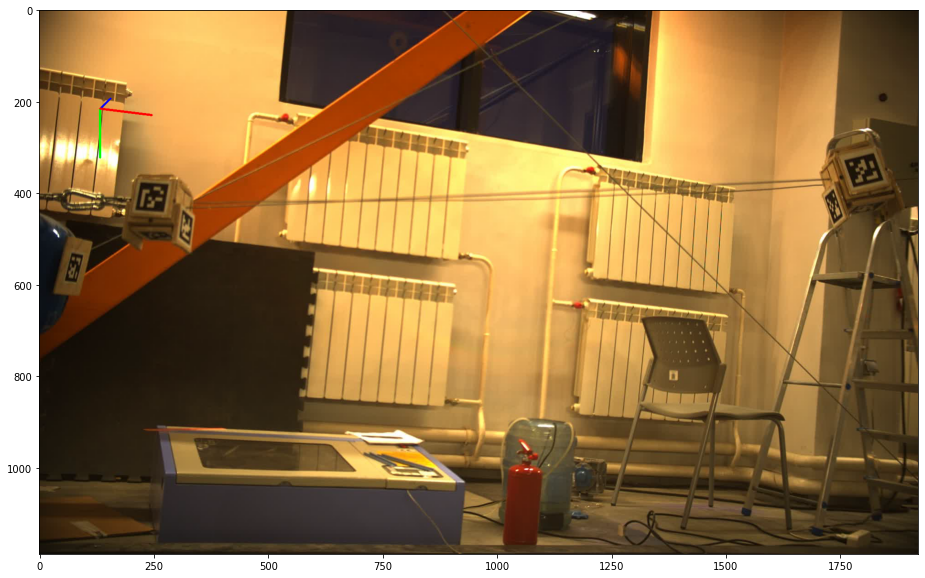

In [132]:
point_img = frame.copy()
aruco.drawAxis(point_img, cameraMatrix, distCoef, block_rvec_img, block_tvec_img, 0.05)
showInRow([point_img])

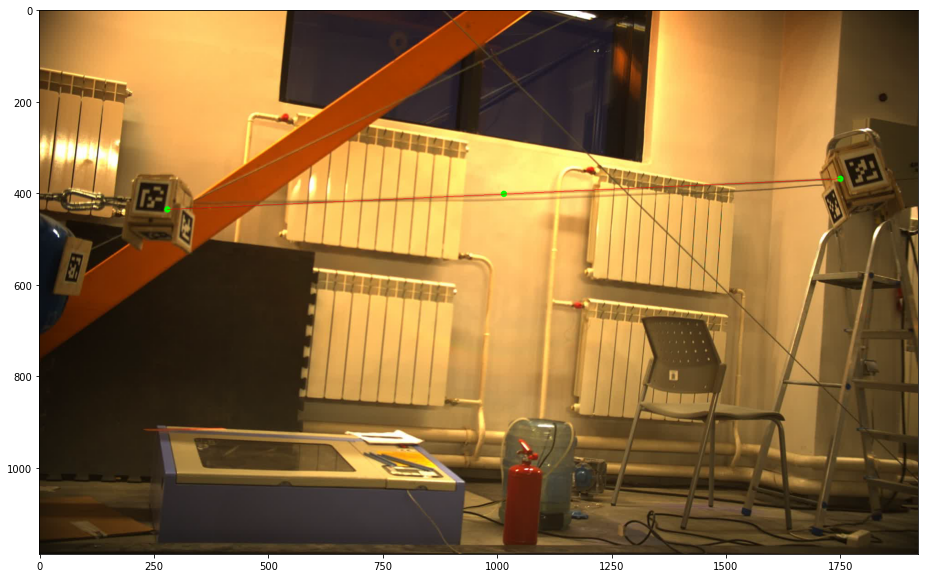

In [133]:
point_img = frame.copy()

cx1 = int(280)
cy1 = int(435)
cv2.circle(point_img, (cx1, cy1), 7, (0, 255, 0), -1)

cx2 = int(1750)
cy2 = int(368)
cv2.circle(point_img, (cx2, cy2), 7, (0, 255, 0), -1)

cxm = (cx1+cx2)//2
cym = (cy1+cy2)//2
cv2.circle(point_img, (cxm, cym), 7, (0, 255, 0), -1)

cv2.line(point_img, (280,435), (1750,368), [255,0,0],1)
# aruco.drawAxis(point_img, cameraMatrix, distCoef, block_rvec_img, block_tvec_img, 0.05)

showInRow([point_img])

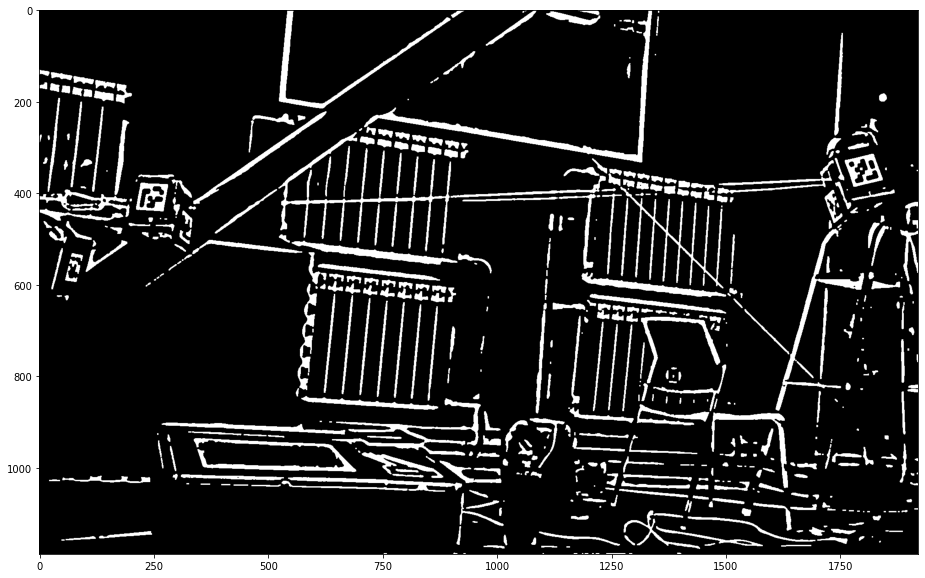

In [ ]:
point_img = frame.copy()
img_line=search_for_line(point_img)

showInRow([img_line])

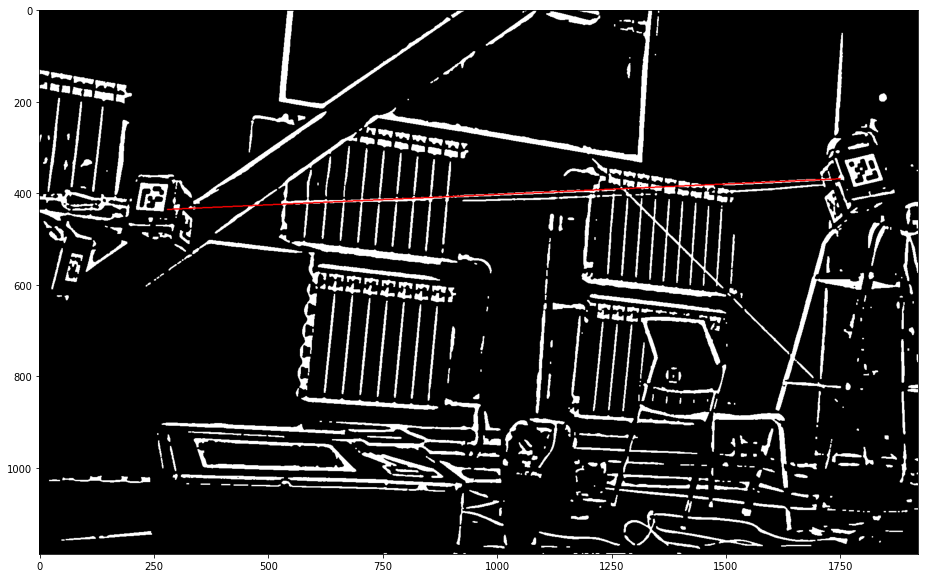

In [137]:
point_img = img_line.copy()
point_img = cv2.cvtColor(point_img, cv2.COLOR_GRAY2RGB)
cv2.line(point_img, (cx1,cy1), (cx2,cy2), [255,0,0],2)
showInRow([point_img])

Finding the Wire

### References
<ul>
<li>Measurement of End-effector Pose Errors and the Cable Profile of Cable-Driven Robot using Monocular Camera by Riby A. Boby</li>
<li>Generating ArUco markers with OpenCV and Python
by Adrian Rosebrock: <a href="https://www.pyimagesearch.com/2020/12/14/generating-aruco-markers-with-opencv-and-python/">link</a></li>
<li>Detecting ArUco Markers with Opencv and python
by Adrian Rosebrock: <a href="https://www.pyimagesearch.com/2020/12/21/detecting-aruco-markers-with-opencv-and-python/">link</a></li>
<li>Detection of ArUco Markers from OpenCv website: <a href="https://docs.opencv.org/master/d5/dae/tutorial_aruco_detection.html">link</a></li>

<li>What is Camera Calibration by Mathworks: <a href="https://www.mathworks.com/help/vision/ug/camera-calibration.html">link</a></li>
<li><a href="https://github.com/qvviko/cv20_project">code link</a></li>
<li><a href="https://github.com/RABKKK/CableDrivenRobotCableModel.git">dataset link<a/></li>
</ul>